In [1]:
%load_ext autoreload
%autoreload 2

In [12]:
from cgr.featurize import MorganFingerprinter, MolFeaturizer, dai
from hydra import initialize, compose
import json
from pathlib import Path
from rdkit import Chem
from rdkit.Chem import Draw
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from collections import Counter
from itertools import product
from ergochemics.standardize import standardize_smiles
from ergochemics.draw import draw_molecule
from IPython.display import SVG
import pandas as pd
from tqdm import tqdm
from functools import lru_cache, partial

with initialize(version_base=None, config_path="../configs/filepaths"):
    cfg = compose(config_name="filepaths")

In [13]:
with open(Path(cfg.raw_data) / "sprhea_240310_v3_mapped_no_subunits.json") as f:
    krs = json.load(f)

std_smi = lru_cache(maxsize=None)(partial(standardize_smiles, quiet=True, neutralization_method="simple"))

In [4]:
# Load coreactant lookups
currency = set()
up_ref = pd.read_csv(Path(cfg.coreactants) / "unpaired.tsv", sep='\t')
p_ref = pd.read_csv(Path(cfg.coreactants) / "paired.tsv", sep='\t')
for _, row in up_ref.iterrows():
    currency.add(row['smiles'])

for _, row in p_ref.iterrows():
    currency.add(row["smiles_1"])
    currency.add(row["smiles_2"])

In [16]:
# Save 2-oxoglutarate and succinate
save = [std_smi(smi) for smi in ["C(CC(=O)O)C(=O)C(=O)O", "C(CC(=O)[O-])C(=O)[O-]"]]
kcs = {}
for elt in tqdm(krs.values()):
    for smi, name in elt['smi2name'].items():
        smi = std_smi(smi)
        if name in save:
            kcs[smi] = name
        elif smi in currency:
            continue
        else:
            kcs[smi] = name
            if name == 'GDP':
                print(smi)


100%|██████████| 18954/18954 [00:14<00:00, 1307.59it/s] 


In [17]:
len(kcs)

8421

In [18]:
mol_featurizer = MolFeaturizer(atom_featurizer=dai)
mfper = MorganFingerprinter(
    radius=3,
    length=2**11,
    mol_featurizer=mol_featurizer,
)

In [19]:
kc_morgan = {}
for smi in kcs.keys():
    mol = Chem.MolFromSmiles(smi)
    if mol is None:
        continue
    else:
        kc_morgan[smi] = mfper.fingerprint(Chem.MolFromSmiles(smi), output_type="count")

In [37]:
n_clusters = int(len(kcs) // 3)
ord_smiles = list(kc_morgan.keys())
X = np.vstack(list(kc_morgan.values()))
X = X / np.linalg.norm(X, axis=1).reshape(-1, 1)
S = X @ X.T
D = 1 - S
ac = AgglomerativeClustering(
    metric='precomputed',
    linkage='single',
    n_clusters=n_clusters,
)
ac.fit(D)

AgglomerativeClustering(linkage='single', metric='precomputed', n_clusters=2807)

In [38]:
cluster_cts = Counter(ac.labels_)
cluster_cts.most_common(15)

[(np.int64(0), 4078),
 (np.int64(20), 190),
 (np.int64(280), 46),
 (np.int64(11), 44),
 (np.int64(54), 44),
 (np.int64(21), 43),
 (np.int64(119), 34),
 (np.int64(346), 31),
 (np.int64(32), 30),
 (np.int64(53), 27),
 (np.int64(648), 27),
 (np.int64(179), 26),
 (np.int64(3), 25),
 (np.int64(23), 22),
 (np.int64(28), 21)]

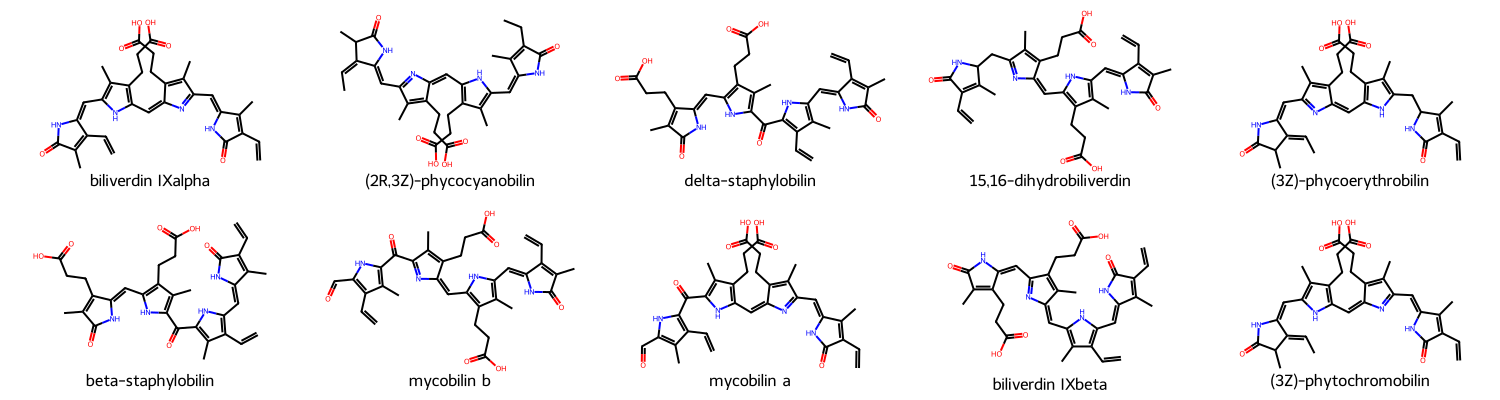

In [39]:
cluster_label = 75
cluster_idxs = np.where(ac.labels_ == cluster_label)[0]
ub = 10
n = min(ub, cluster_cts[cluster_label])
disp_mols = [Chem.MolFromSmiles(ord_smiles[idx]) for idx in cluster_idxs[:n]]
Draw.MolsToGridImage(
    disp_mols,
    molsPerRow=5,
    subImgSize=(300, 200),
    legends=[kcs[ord_smiles[idx]] for idx in cluster_idxs[:n]],
)

In [ ]:
n

10